In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import requests
import json
import datetime as dt
import warnings

state_lockdown_file = pd.read_csv("data_sources/lockdown_us.csv")
state_deaths_cases_file = pd.read_csv("data_sources/liz-friedman-us-covid-19-data-from-nytimes/us-states.csv")
county_population_file = pd.read_csv("data_sources/qventus-covid-19-localized-scenario-planner/qventus-covid-19-localized-scenario-planner/covid_county_population_usafacts.csv")


In [2]:
url = "https://api.covidtracking.com/v1/states/current.json"
state_current_data = (requests.get(url)).json()
state_current_data=pd.DataFrame(state_current_data)
state_current_data['date'] = pd.to_datetime(state_current_data['date'], format='%Y%m%d')


In [3]:
url = "https://api.covidtracking.com/v1/states/daily.json"
state_daily_data = (requests.get(url)).json()
state_daily_data=pd.DataFrame(state_daily_data)
state_daily_data['date'] = pd.to_datetime(state_daily_data['date'], format='%Y%m%d')
state_daily_data = state_daily_data.set_index("state")
state_daily_data = state_daily_data.drop(["AS","GU","MP","PR", "VI","DC"])
state_daily_data = state_daily_data.reset_index()

#loop for summing for total state cases
states = state_daily_data["state"].unique()
total_cases_by_state = []


for state in states:
    state_case = state_daily_data.loc[state_daily_data["state"] == state]
    total_cases_by_state.append(state_case["positive"].sum())

state_daily_data

,state,date,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,AK,2020-09-02,6233.0,370651.0,NaN,46.0,NaN,NaN,NaN,10.0,...,376884,0,0,0eaef7dbd992985ab0f8d68e7290a358f8b6e44f,0,0,0,0,0,
1,AL,2020-09-02,128239.0,835994.0,NaN,959.0,14753.0,NaN,1501.0,NaN,...,964233,17,215,fca39761bbc6be0099b27c6b880230afcfeabc1b,0,0,0,0,0,
2,AR,2020-09-02,62112.0,675337.0,NaN,435.0,4341.0,NaN,NaN,90.0,...,737449,27,35,3c318be701fbb9138ced6d0286e3874d5edf35fe,0,0,0,0,0,
3,AZ,2020-09-02,202861.0,1011066.0,NaN,752.0,21449.0,248.0,NaN,146.0,...,1213927,21,44,36685dfe649f351d4b5be90630ede6819fded584,0,0,0,0,0,
4,CA,2020-09-02,712052.0,10868318.0,NaN,4851.0,NaN,1339.0,NaN,NaN,...,11580370,145,0,61ce2c9982d886c3da71512bb44db09f2bd735a6,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9192,WA,2020-01-24,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,6f40087f42d06db4121e09b184785b4110cd4df8,0,0,0,0,0,
9193,MA,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,c84abd17d6845385fcfbf5b9603dc7694a807064,0,0,0,0,0,
9194,WA,2020-01-23,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,978c05d8a7a9d46e9fa826d83215f5b9732f2c6d,0,0,0,0,0,
9195,MA,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,46dfacd26597d739a2e962d50bf5b49624bc0608,0,0,0,0,0,


In [4]:
#loop for finding positive rate per month


months = [1,2,3,4,5,6,7,8]
positive_rates = []
state_list = []
month_list = []

for state in states:
    
    single_state = state_daily_data.loc[state_daily_data["state"] == state]
    single_state['date'] = pd.to_datetime(single_state['date'], format='%Y%m%d')    
    single_state = single_state.sort_values("date")
    single_state['month'] = pd.DatetimeIndex(single_state['date']).month
    single_state['day'] = pd.DatetimeIndex(single_state['date']).day
    for month in months:
        print(state)
        try:
            single_month = single_state.loc[single_state["month"] == month]
            single_month = single_month.reset_index()
            first_row = single_month.iloc[0]
            last_row = single_month.iloc[-1]
            month_pos = int(last_row["positive"]) - int(first_row["positive"])
            month_tot = int(last_row["posNeg"]) - int(first_row["posNeg"])
            positive_rate = month_pos / month_tot
            positive_rate = "{:.2%}".format(positive_rate)
            positive_rates.append(positive_rate)
            state_list.append(state)
            month_list.append(month)
            
            
        except IndexError:
            print("no data for this month")
        except ValueError:
            print("value issue")
        except ZeroDivisionError:
            print("month total = 0")

<ipython-input-4-53084f5c8057>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_state['date'] = pd.to_datetime(single_state['date'], format='%Y%m%d')


AK
no data for this month
AK
no data for this month
AK
AK
AK
AK
AK
AK
AL
no data for this month
AL
no data for this month
AL
AL
AL
AL
AL
AL
AR
no data for this month
AR
no data for this month
AR
AR
AR
AR
AR
AR
AZ
no data for this month
AZ
no data for this month
AZ
AZ
AZ
AZ
AZ
AZ
CA
no data for this month
CA
no data for this month
CA
CA
CA
CA
CA
CA
CO
no data for this month
CO
no data for this month
CO
CO
CO
CO
CO
CO
CT
no data for this month
CT
no data for this month
CT
CT
CT
CT
CT
CT
DE
no data for this month
DE
no data for this month
DE
DE
DE
DE
DE
DE
FL
no data for this month
FL
no data for this month
FL
FL
FL
FL
FL
FL
GA
no data for this month
GA
no data for this month
GA
GA
GA
GA
GA
GA
HI
no data for this month
HI
no data for this month
HI
HI
HI
HI
HI
HI
IA
no data for this month
IA
no data for this month
IA
IA
IA
IA
IA
IA
ID
no data for this month
ID
no data for this month
ID
ID
ID
ID
ID
ID
IL
no data for this month
IL
no data for this month
IL
IL
IL
IL
IL
IL
IN
no data for this 

In [5]:
pos_rates_df = pd.DataFrame({
    "State": state_list,
    "Positive Rate": positive_rates,
    "Month": month_list
})
pos_rates_df.head(500)

,State,Positive Rate,Month
0,AK,3.21%,3
1,AK,1.53%,4
2,AK,0.22%,5
3,AK,0.82%,6
4,AK,2.27%,7
...,...,...,...
293,WY,5.83%,4
294,WY,2.34%,5
295,WY,6.77%,6
296,WY,6.18%,7


In [6]:
#States total population
state_pop = []
states = county_population_file["State"].unique()

for state in states:
    state_df = county_population_file.loc[county_population_file["State"] == state]
    state_pop.append(state_df["population"].sum())
    
population_df = pd.DataFrame({
    "state": states,
    "population": state_pop
})



In [7]:
state_deaths_cases_file.head()
state_deaths_cases_file = state_deaths_cases_file.rename(columns={"state":"State"})
state_deaths_cases_file = state_deaths_cases_file.sort_values("State")

state_deaths_cases_file['month'] = pd.DatetimeIndex(state_deaths_cases_file['date']).month
state_deaths_cases_file['day'] = pd.DatetimeIndex(state_deaths_cases_file['date']).day

state_deaths_cases_file.head()

,date,State,fips,cases,deaths,month,day
2874,2020-04-24,Alabama,1,6026,209,4,24
7549,2020-07-18,Alabama,1,65234,1286,7,18
3589,2020-05-07,Alabama,1,9046,369,5,7
3699,2020-05-09,Alabama,1,9668,390,5,9
9254,2020-08-18,Alabama,1,110361,1936,8,18


In [8]:
state_deaths_cases_file = state_deaths_cases_file.dropna()
state_deaths_cases_file = state_deaths_cases_file.set_index("State")
state_deaths_cases_file.head()

,date,fips,cases,deaths,month,day
State,,,,,,
Alabama,2020-04-24,1,6026,209,4,24
Alabama,2020-07-18,1,65234,1286,7,18
Alabama,2020-05-07,1,9046,369,5,7
Alabama,2020-05-09,1,9668,390,5,9
Alabama,2020-08-18,1,110361,1936,8,18


In [9]:
state_deaths_cases_file.to_csv('state_deaths.csv')

In [10]:
first_state_deaths_cases_file = state_deaths_cases_file.loc[["Arizona","Florida","Kansas",
                                                       "New York","Washington","Wisconsin"],["date","deaths"]]

In [11]:
positive_closings = state_deaths_cases_file.loc[["California","Florida","New York", 
                                                "Kansas","Texas","Washington"],
                                                ["date","cases","month"]]
positive_closings = positive_closings.sort_values("date")
positive_closings

,date,cases,month
State,,,
Washington,2020-01-21,1,1
Washington,2020-01-22,1,1
Washington,2020-01-23,1,1
Washington,2020-01-24,1,1
Washington,2020-01-25,1,1
...,...,...,...
Kansas,2020-08-23,37726,8
Florida,2020-08-23,600563,8
Texas,2020-08-23,602144,8


In [12]:
california = positive_closings.loc["California"]
cali_closings = california.loc[(california["date"] >= "2020-03-19") & (california["date"] <= "2020-05-12"),:]
#cali_closings

kansas = positive_closings.loc["Kansas"]
ks_closings = kansas.loc[(kansas["date"] >= "2020-04-19") & (kansas["date"] <= "2020-05-03"),:]
#ks_closings

florida = positive_closings.loc["Florida"]
fl_closings = florida.loc[(florida["date"]>= "2020-04-03") & (florida["date"]<= "2020-04-30"),:]
#fl_closings

new_york = positive_closings.loc["New York"]
ny_closings = new_york.loc[(new_york["date"]>= "2020-03-22") & (new_york["date"]<= "2020-05-15"),:]
#ny_closings

washington = positive_closings.loc["Washington"]
wa_closings = washington.loc[(washington["date"]>= "2020-03-23") & (washington["date"]<= "2020-05-04"),:]
#wa_closings

texas = positive_closings.loc["Texas"]
tx_closings = texas.loc[(texas["date"]>= "2020-04-02") & (texas["date"]<= "2020-04-30"),:]
#tx_closings


In [13]:
california = positive_closings.loc["California"]
cali_reo = california.loc[(california["date"] >= "2020-05-12") & (california["date"] <= "2020-08-23"),:]
#cali_reo

kansas = positive_closings.loc["Kansas"]
ks_reo = kansas.loc[(kansas["date"] >= "2020-05-03") & (kansas["date"] <= "2020-08-23"),:]
#ks_reo

florida = positive_closings.loc["Florida"]
fl_reo = florida.loc[(florida["date"] >= "2020-04-30") & (florida["date"] <= "2020-08-23"),:]
#fl_reo

new_york = positive_closings.loc["New York"]
ny_reo = new_york.loc[(new_york["date"]>= "2020-05-15") & (new_york["date"] <= "2020-08-23"),:]
#ny_reo

washington = positive_closings.loc["Washington"]
wa_reo = washington.loc[(washington["date"] >= "2020-05-04") & (washington["date"] <= "2020-08-23"),:]
#wa_reo

texas = positive_closings.loc["Texas"]
tx_reo = texas.loc[(texas["date"] >= "2020-04-30") & (texas["date"] <= "2020-08-23"),:]
#tx_reo

In [14]:
ks_data = first_state_deaths_cases_file.loc[["Kansas"],["date","deaths"]]
ks_data=ks_data.sort_values("deaths")

In [15]:
state_lockdown_file[pd.isnull(state_lockdown_file['County'])]
state_lockdown_file[pd.isnull(state_lockdown_file['Type'])]

state_lockdown_file['month'] = pd.DatetimeIndex(state_lockdown_file['Date']).month
state_lockdown_file['day'] = pd.DatetimeIndex(state_lockdown_file['Date']).day

state_lockdown_file

,Country,State,County,Date,Type,month,day
0,United States,Alabama,NaN,2020-04-04,Stay at home,4,4
1,United States,Alabama,Birmingham,2020-03-24,Shelter in place,3,24
2,United States,Alaska,NaN,2020-03-28,Stay at home,3,28
3,United States,Arizona,NaN,2020-03-31,Stay at home,3,31
4,United States,California,NaN,2020-03-19,Stay at home,3,19
...,...,...,...,...,...,...,...
168,United States,Virginia,NaN,2020-03-30,Stay at home,3,30
169,United States,Washington,NaN,2020-03-23,Stay at home,3,23
170,United States,West Virginia,NaN,2020-03-24,Stay at home,3,24
171,United States,Wisconsin,NaN,2020-03-25,Stay at home,3,25


In [16]:
state_current_narrow = state_current_data[["state","positive","death","hospitalized"]]
state_current_drop = state_current_narrow.dropna()
state_current_drop
state_current_drop = state_current_drop.set_index('state')
state_current_drop

state_current_df = pd.merge(state_current_drop, population_df, on='state')
state_current_df.head()

,state,positive,death,hospitalized,population
0,AL,128239,2217,14753.0,4903185
1,AR,62112,841,4341.0,3017804
2,AZ,202861,5065,21449.0,7278717
3,CO,57775,1853,7053.0,5758736
4,CT,53108,4467,11180.0,3565287


In [17]:
special_states_data = state_current_drop.loc[["AZ","FL","KS","NY","WA","WI"],["death","hospitalized"]]
special_states_data

,death,hospitalized
state,,
AZ,5065,21449.0
FL,11651,39611.0
KS,458,2361.0
NY,25336,89995.0
WA,1931,6787.0
WI,1150,5916.0


In [18]:
states_early_lock = state_current_drop.loc[["KY","MA","NY","WA","WI"],["death","hospitalized"]]
states_early_lock

states_late_lock = state_current_drop.loc[["FL","GA","KS","SC","AZ"],["death","hospitalized"]]
states_late_lock


,death,hospitalized
state,,
FL,11651,39611.0
GA,5795,25025.0
KS,458,2361.0
SC,2794,7948.0
AZ,5065,21449.0


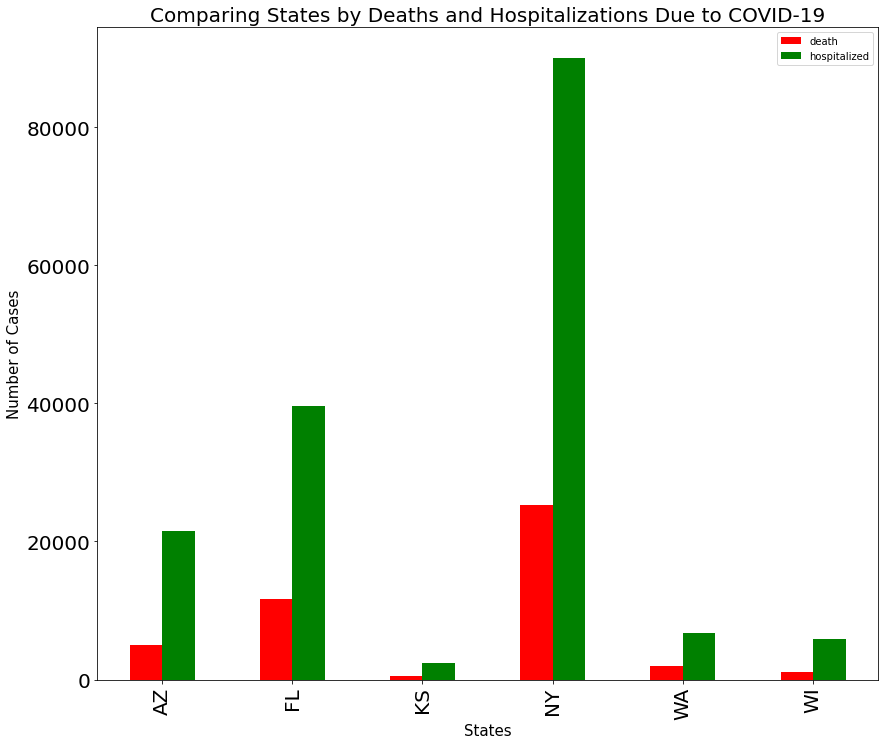

In [19]:
my_colors = "rgbkymc"
plot_pandas = special_states_data.plot.bar(figsize=(14,12),color= my_colors ,fontsize=20)
plt.xlabel("States", fontsize = 15)
plt.ylabel("Number of Cases", fontsize = 15)
plt.title("Comparing States by Deaths and Hospitalizations Due to COVID-19", fontsize=20)

plt.savefig("Images/deaths_vs_hospitalizations.png")

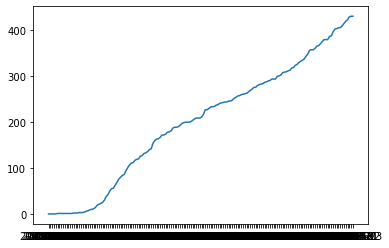

In [20]:
plt.plot(ks_data["date"],ks_data["deaths"])

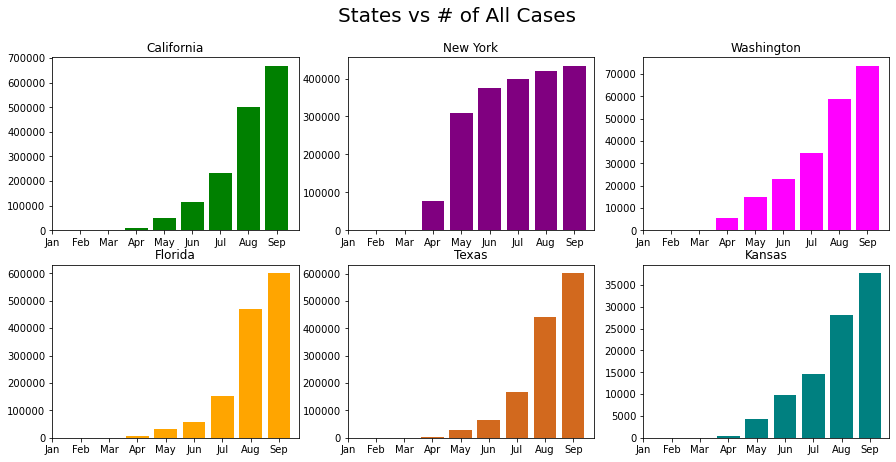

<Figure size 432x288 with 0 Axes>

In [42]:
fig = plt.figure(figsize=(15,7))

fig.suptitle('States vs # of All Cases', 
             fontsize=20)

ax1 = fig.add_subplot(231)
ax1.set_title('California')

ax1.bar(california['month'],
         california['cases'], 
         color='green')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"])


ax2 = fig.add_subplot(232)
ax2.set_title('New York')

ax2.bar(new_york['month'],
         new_york['cases'], 
         color='purple')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"])

ax3 = fig.add_subplot(233)
ax3.set_title('Washington')

ax3.bar(washington['month'],
         washington['cases'], 
         color='magenta')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"])

ax4 = fig.add_subplot(234)
ax4.set_title('Florida')

ax4.bar(florida['month'],
         florida['cases'], 
         color='orange')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"])

ax5 = fig.add_subplot(235)
ax5.set_title('Texas')

ax5.bar(texas['month'],
         texas['cases'], 
         color='chocolate')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"])

ax6 = fig.add_subplot(236)
ax6.set_title('Kansas')

ax6.bar(kansas['month'],
         kansas['cases'], 
         color='teal')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"])

plt.show()
plt.savefig("Images/states_vs_cases.png")

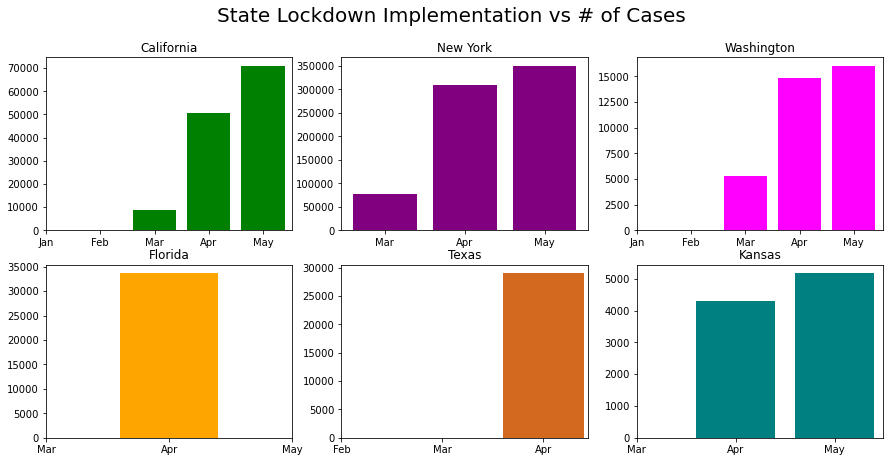

<Figure size 432x288 with 0 Axes>

In [23]:
fig = plt.figure(figsize=(15,7))

fig.suptitle('State Lockdown Implementation vs # of Cases', 
             fontsize=20)

ax1 = fig.add_subplot(231)
ax1.set_title('California')

ax1.bar(cali_closings['month'],
         cali_closings['cases'], 
         color='green')
plt.xticks([1, 2, 3, 4, 5],["Jan", "Feb", "Mar", "Apr", "May"])

ax2 = fig.add_subplot(232)
ax2.set_title('New York')

ax2.bar(ny_closings['month'],
         ny_closings['cases'], 
         color='purple')
plt.xticks([3, 4, 5],["Mar", "Apr", "May"])

ax3 = fig.add_subplot(233)
ax3.set_title('Washington')

ax3.bar(wa_closings['month'],
         wa_closings['cases'], 
         color='magenta')
plt.xticks([1, 2, 3, 4, 5],["Jan", "Feb", "Mar", "Apr", "May"])

ax4 = fig.add_subplot(234)
ax4.set_title('Florida')

ax4.bar(fl_closings['month'],
         fl_closings['cases'], 
         color='orange')
plt.xticks([3, 4, 5],["Mar", "Apr", "May"])

ax5 = fig.add_subplot(235)
ax5.set_title('Texas')

ax5.bar(tx_closings['month'],
         tx_closings['cases'], 
         color='chocolate')
plt.xticks([2, 3, 4],["Feb", "Mar", "Apr"])

ax6 = fig.add_subplot(236)
ax6.set_title('Kansas')

ax6.bar(ks_closings['month'],
         ks_closings['cases'], 
         color='teal')
plt.xticks([3, 4, 5],["Mar", "Apr", "May"])

plt.show()
plt.savefig("Images/lockdown_vs_cases.png")

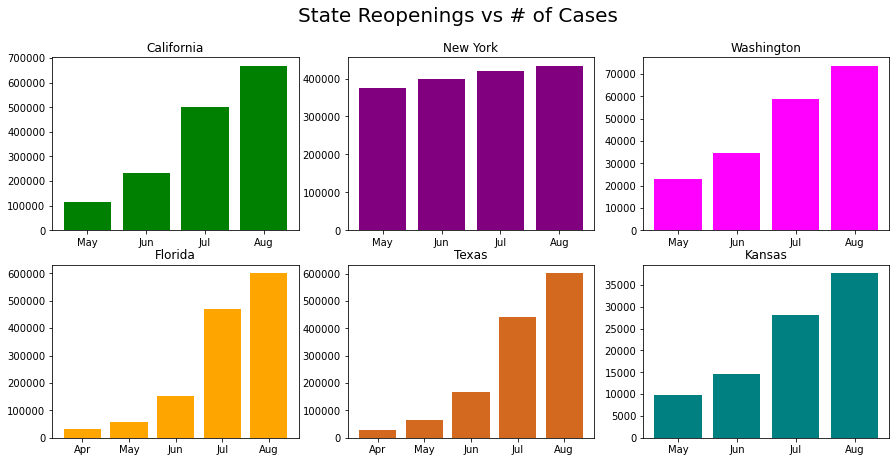

<Figure size 432x288 with 0 Axes>

In [25]:
fig = plt.figure(figsize=(15,7))

fig.suptitle('State Reopenings vs # of Cases', 
             fontsize=20)

ax1 = fig.add_subplot(231)
ax1.set_title('California')

ax1.bar(cali_reo['month'],
         cali_reo['cases'], 
         color='green')
plt.xticks([5, 6, 7, 8],["May", "Jun", "Jul", "Aug"])

ax2 = fig.add_subplot(232)
ax2.set_title('New York')

ax2.bar(ny_reo['month'],
         ny_reo['cases'], 
         color='purple')
plt.xticks([5, 6, 7, 8],["May", "Jun", "Jul", "Aug"])

ax3 = fig.add_subplot(233)
ax3.set_title('Washington')

ax3.bar(wa_reo['month'],
         wa_reo['cases'], 
         color='magenta')
plt.xticks([5, 6, 7, 8],["May", "Jun", "Jul", "Aug"])

ax4 = fig.add_subplot(234)
ax4.set_title('Florida')

ax4.bar(fl_reo['month'],
         fl_reo['cases'], 
         color='orange')
plt.xticks([4, 5, 6, 7, 8],["Apr", "May", "Jun", "Jul", "Aug"])

ax5 = fig.add_subplot(235)
ax5.set_title('Texas')

ax5.bar(tx_reo['month'],
         tx_reo['cases'], 
         color='chocolate')
plt.xticks([4, 5, 6, 7, 8],["Apr", "May", "Jun", "Jul", "Aug"])

ax6 = fig.add_subplot(236)
ax6.set_title('Kansas')

ax6.bar(ks_reo['month'],
         ks_reo['cases'], 
         color='teal')
plt.xticks([5, 6, 7, 8],["May", "Jun", "Jul", "Aug"])

plt.show()
plt.savefig("Images/reopenings_vs_cases.png")

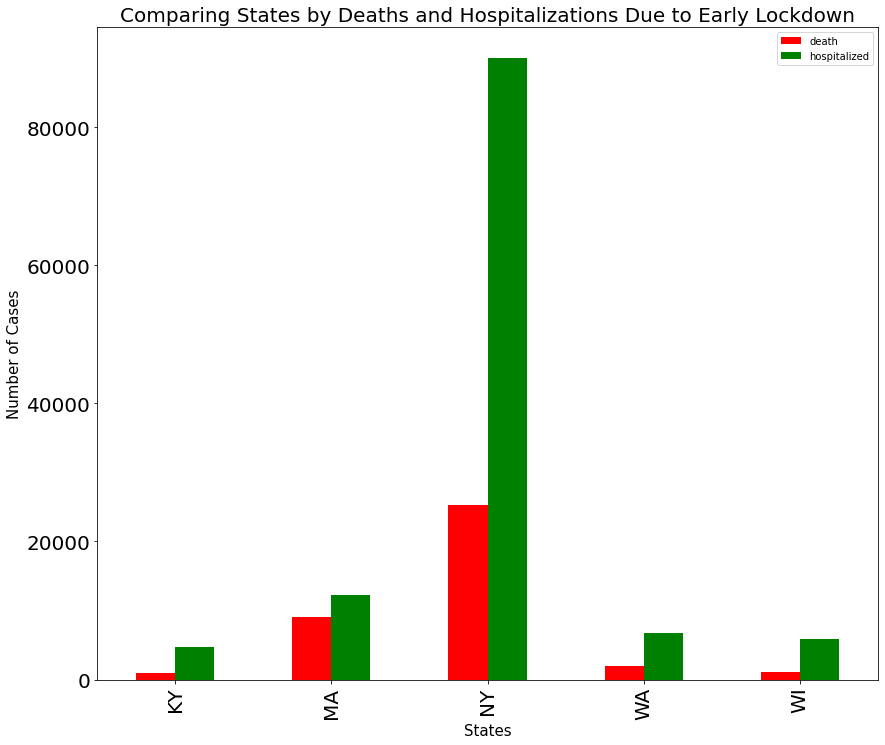

In [26]:
my_colors = "rgbkymc"
plot_pandas = states_early_lock.plot.bar(figsize=(14,12),color= my_colors ,fontsize=20)
plt.xlabel("States", fontsize = 15)
plt.ylabel("Number of Cases", fontsize = 15)
plt.title("Comparing States by Deaths and Hospitalizations Due to Early Lockdown", fontsize=20)
plt.savefig("Images/hospitalizations_vs_early_lockdown.png")

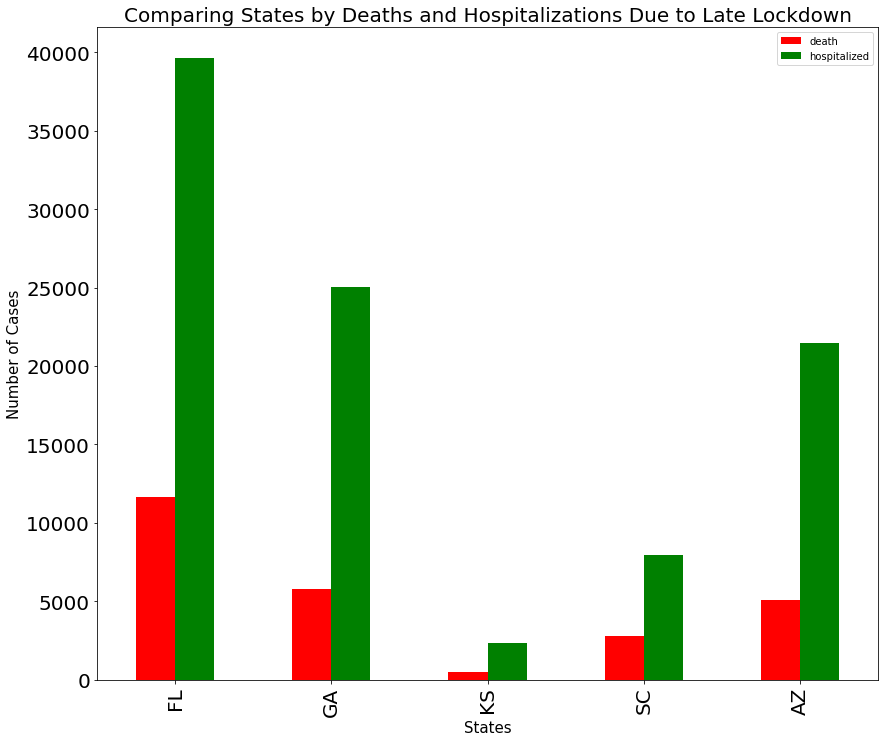

In [27]:
my_colors = "rgbkymc"
plot_pandas = states_late_lock.plot.bar(figsize=(14,12),color= my_colors ,fontsize=20)
plt.xlabel("States", fontsize = 15)
plt.ylabel("Number of Cases", fontsize = 15)
plt.title("Comparing States by Deaths and Hospitalizations Due to Late Lockdown", fontsize=20)
plt.savefig("Images/hospitalizations_vs_late_lockdown.png")

In [28]:
summer_fun = state_deaths_cases_file.loc[["California","Florida","Hawaii",
                                                "Missouri","Texas","Nevada"],
                                                ["date","cases","month"]]

In [29]:
california_summer = summer_fun.loc["California"]
cali_summer = california_summer.loc[(california_summer["date"] >= "2020-05-25") & (california_summer["date"] <= "2020-09-07"),:]

hawaii_summer = summer_fun.loc["Hawaii"]
hi_summer = hawaii_summer.loc[(hawaii_summer["date"] >= "2020-05-25") & (hawaii_summer["date"] <= "2020-09-07"),:]

florida_summer = summer_fun.loc["Florida"]
fl_summer = florida_summer.loc[(florida_summer["date"] >= "2020-05-25") & (florida_summer["date"] <= "2020-09-07"),:]

missouri_summer = summer_fun.loc["Missouri"]
mo_summer = missouri_summer.loc[(missouri_summer["date"] >= "2020-05-25") & (missouri_summer["date"] <= "2020-09-07"),:]

nevada_summer = summer_fun.loc["Nevada"]
nv_summer = nevada_summer.loc[(nevada_summer["date"] >= "2020-05-25") & (nevada_summer["date"] <= "2020-09-07"),:]

texas_summer = summer_fun.loc["Texas"]
tx_summer = texas_summer.loc[(texas_summer["date"] >= "2020-05-25") & (texas_summer["date"] <= "2020-09-07"),:]


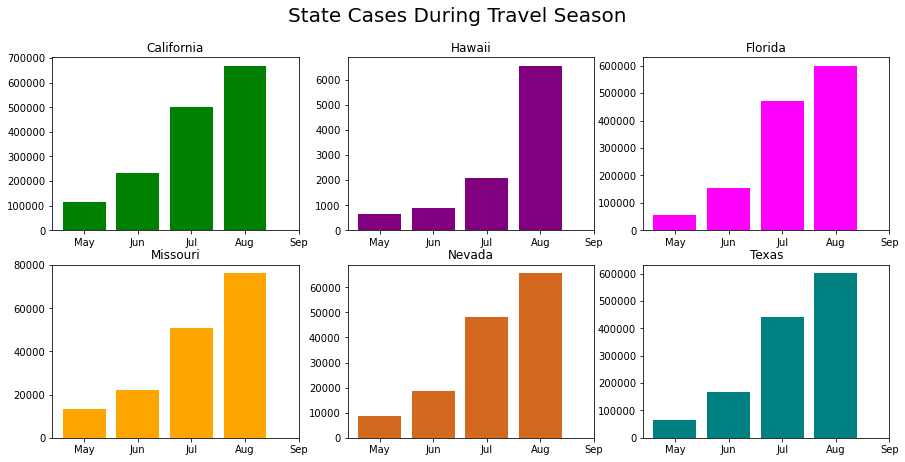

<Figure size 432x288 with 0 Axes>

In [31]:
fig = plt.figure(figsize=(15,7))

fig.suptitle('State Cases During Travel Season', 
             fontsize=20)

ax1 = fig.add_subplot(231)
ax1.set_title('California')

ax1.bar(cali_summer['month'],
         cali_summer['cases'], 
         color='green')
plt.xticks([5, 6, 7, 8, 9],["May", "Jun", "Jul", "Aug", "Sep"])

ax2 = fig.add_subplot(232)
ax2.set_title('Hawaii')

ax2.bar(hi_summer['month'],
         hi_summer['cases'], 
         color='purple')
plt.xticks([5, 6, 7, 8, 9],["May", "Jun", "Jul", "Aug", "Sep"])

ax3 = fig.add_subplot(233)
ax3.set_title('Florida')

ax3.bar(fl_summer['month'],
         fl_summer['cases'], 
         color='magenta')
plt.xticks([5, 6, 7, 8, 9],["May", "Jun", "Jul", "Aug", "Sep"])

ax4 = fig.add_subplot(234)
ax4.set_title('Missouri')

ax4.bar(mo_summer['month'],
         mo_summer['cases'], 
         color='orange')
plt.xticks([5, 6, 7, 8, 9],["May", "Jun", "Jul", "Aug", "Sep"])

ax5 = fig.add_subplot(235)
ax5.set_title('Nevada')

ax5.bar(nv_summer['month'],
         nv_summer['cases'], 
         color='chocolate')
plt.xticks([5, 6, 7, 8, 9],["May", "Jun", "Jul", "Aug", "Sep"])

ax6 = fig.add_subplot(236)
ax6.set_title('Texas')

ax6.bar(tx_summer['month'],
         tx_summer['cases'], 
         color='teal')
plt.xticks([5, 6, 7, 8, 9],["May", "Jun", "Jul", "Aug", "Sep"])

plt.show()
plt.savefig("Images/travel_season.png")

In [32]:
mask_mandate_with = state_deaths_cases_file.loc[["California","Texas","Hawaii","Kansas","New York"],["date","cases","month"]]

mask_cali = mask_mandate_with.loc["California"]
ca_mandate =  mask_cali.loc[(mask_cali["date"] >= "2020-06-18") & (mask_cali["date"] <= "2020-08-24"),:]
                                                
mask_tx = mask_mandate_with.loc["Texas"]
tx_mandate =  mask_tx.loc[(mask_tx["date"] >= "2020-07-03") & (mask_tx["date"] <= "2020-08-24"),:]

mask_hi = mask_mandate_with.loc["Hawaii"]                                                
hi_mandate =  mask_hi.loc[(mask_hi["date"] >= "2020-04-20") & (mask_hi["date"] <= "2020-08-24"),:]
                                             
mask_ks = mask_mandate_with.loc["Kansas"]
ks_mandate =  mask_ks.loc[(mask_ks["date"] >= "2020-07-03") & (mask_ks["date"] <= "2020-08-24"),:]
                                              
mask_ny = mask_mandate_with.loc["New York"]
ny_mandate =  mask_ny.loc[(mask_ny["date"] >= "2020-04-17") & (mask_ny["date"] <= "2020-08-24"),:]


In [33]:
ny_mandate

,date,cases,month
State,,,
New York,2020-07-12,406403,7
New York,2020-08-23,434462,8
New York,2020-08-09,425568,8
New York,2020-07-06,402338,7
New York,2020-08-08,425055,8
...,...,...,...
New York,2020-05-18,356278,5
New York,2020-08-11,426713,8
New York,2020-05-10,340657,5


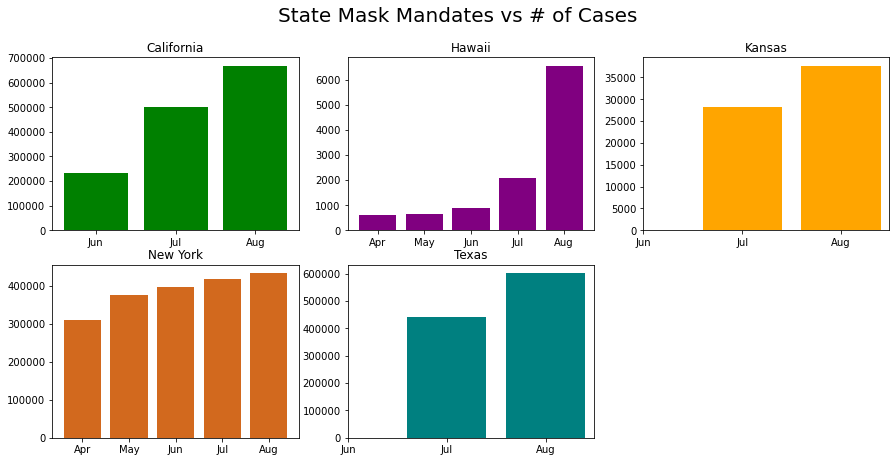

<Figure size 432x288 with 0 Axes>

In [34]:
fig = plt.figure(figsize=(15,7))

fig.suptitle('State Mask Mandates vs # of Cases', 
             fontsize=20)

ax1 = fig.add_subplot(231)
ax1.set_title('California')

ax1.bar(ca_mandate['month'],
         ca_mandate['cases'], 
         color='green')
plt.xticks([6, 7, 8,],["Jun", "Jul", "Aug"])

ax2 = fig.add_subplot(232)
ax2.set_title('Hawaii')

ax2.bar(hi_mandate['month'],
         hi_mandate['cases'], 
         color='purple')
plt.xticks([4, 5, 6, 7, 8],["Apr", "May", "Jun", "Jul", "Aug"])

ax3 = fig.add_subplot(233)
ax3.set_title('Kansas')

ax3.bar(ks_mandate['month'],
         ks_mandate['cases'], 
         color='orange')
plt.xticks([6, 7, 8],["Jun", "Jul", "Aug"])

ax4 = fig.add_subplot(234)
ax4.set_title('New York')

ax4.bar(ny_mandate['month'],
         ny_mandate['cases'], 
         color='chocolate')
plt.xticks([4, 5, 6, 7, 8],["Apr", "May", "Jun", "Jul", "Aug"])

ax5 = fig.add_subplot(235)
ax5.set_title('Texas')

ax5.bar(tx_mandate['month'],
         tx_mandate['cases'], 
         color='teal')
         #width=0.5)
plt.xticks([6, 7, 8],["Jun", "Jul", "Aug"])

plt.show()
plt.savefig("Images/mask_mandates.png")

In [35]:
mask_mandate_without = state_deaths_cases_file.loc[["Florida","Missouri","Arizona","Arkansas","North Dakota"],["date","cases","month"]]

mask_fl = mask_mandate_without.loc["Florida"]
fl_without =  mask_fl.loc[(mask_fl["date"] >= "2020-03-01") & (mask_fl["date"] <= "2020-08-24"),:]

mask_mo = mask_mandate_without.loc["Missouri"]
mo_without =  mask_mo.loc[(mask_mo["date"] >= "2020-03-01") & (mask_mo["date"] <= "2020-08-24"),:]

mask_az = mask_mandate_without.loc["Arizona"]
az_without =  mask_az.loc[(mask_az["date"] >= "2020-03-01") & (mask_az["date"] <= "2020-08-24"),:]

mask_ak = mask_mandate_without.loc["Arkansas"]
ak_without =  mask_ak.loc[(mask_ak["date"] >= "2020-03-01") & (mask_ak["date"] <= "2020-08-24"),:]

mask_nd = mask_mandate_without.loc["North Dakota"]
nd_without =  mask_nd.loc[(mask_nd["date"] >= "2020-03-01") & (mask_nd["date"] <= "2020-08-24"),:]


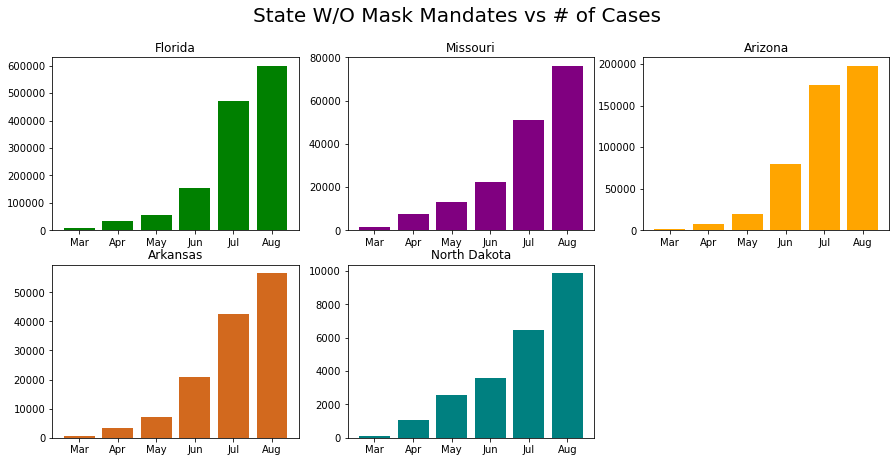

<Figure size 432x288 with 0 Axes>

In [36]:
fig = plt.figure(figsize=(15,7))

fig.suptitle('State W/O Mask Mandates vs # of Cases', 
             fontsize=20)

ax1 = fig.add_subplot(231)
ax1.set_title('Florida')

ax1.bar(fl_without['month'],
         fl_without['cases'], 
         color='green')
plt.xticks([3, 4, 5, 6, 7, 8,],["Mar", "Apr", "May", "Jun", "Jul", "Aug"])

ax2 = fig.add_subplot(232)
ax2.set_title('Missouri')

ax2.bar(mo_without['month'],
         mo_without['cases'], 
         color='purple')
plt.xticks([3, 4, 5, 6, 7, 8,],["Mar", "Apr", "May", "Jun", "Jul", "Aug"])

ax3 = fig.add_subplot(233)
ax3.set_title('Arizona')

ax3.bar(az_without['month'],
         az_without['cases'], 
         color='orange')
plt.xticks([3, 4, 5, 6, 7, 8,],["Mar", "Apr", "May", "Jun", "Jul", "Aug"])

ax4 = fig.add_subplot(234)
ax4.set_title('Arkansas')

ax4.bar(ak_without['month'],
         ak_without['cases'], 
         color='chocolate')
plt.xticks([3, 4, 5, 6, 7, 8,],["Mar", "Apr", "May", "Jun", "Jul", "Aug"])

ax5 = fig.add_subplot(235)
ax5.set_title('North Dakota')

ax5.bar(nd_without['month'],
         nd_without['cases'], 
         color='teal')
plt.xticks([3, 4, 5, 6, 7, 8,],["Mar", "Apr", "May", "Jun", "Jul", "Aug"])

plt.show()
plt.savefig("Images/without_mandates.png")